# Avaliacao de documentos bancários
O dataset abaixo contem dados extraídos de imagens de notas falsas e notas reais. Foi usado uma wavelet transform para obter os dados da tabela abaixo:

**Variaveis**

| **Nome da Variável** | **Função**  | **Tipo**     | **Descrição**                           | **Unidades** | **Valores Ausentes** |
|----------------------|-------------|--------------|-----------------------------------------|--------------|----------------------|
| variância            | Feature  | Contínuo     | variância da imagem transformada por Wavelet |              | não                  |
| assimetria           | Feature  | Contínuo     | assimetria da imagem transformada por Wavelet |              | não                  |
| curtose              | Feature  | Contínuo     | curtose da imagem transformada por Wavelet |              | não                  |
| entropia             | Feature  | Contínuo     | entropia da imagem                      |              | não                  |
| classe               | Alvo          | Inteiro      |                                         |              | não                  |

Nesse projeto iremos inicialmente avaliar a perfomance do [RandomForest](https://https://colab.research.google.com/drive/1aOPbsIG3IYEAOUOgsY1BxPvMm9EaF_ZO#scrollTo=_pgb85TtOe8z&line=14&uniqifier=1) nos dados originais, posteriormente usaremos uma GAN para forjar dados e avaliaremos o desempenho do modelo na classificação desses dados.

In [ ]:
!pip install ucimlrepo

In [ ]:

# Bibliotecas
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import tensorflow as tf
from sklearn.model_selection import train_test_split
# Importing GridSearchCV
from sklearn.model_selection import GridSearchCV # Import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [ ]:
#Importando os dados do dataset

# fetch dataset
banknote_authentication = fetch_ucirepo(id=267)

# data (as pandas dataframes)
X = banknote_authentication.data.features
y = banknote_authentication.data.targets

# metadata
print(banknote_authentication.metadata)

# variable information
print(banknote_authentication.variables)


{'uci_id': 267, 'name': 'Banknote Authentication', 'repository_url': 'https://archive.ics.uci.edu/dataset/267/banknote+authentication', 'data_url': 'https://archive.ics.uci.edu/static/public/267/data.csv', 'abstract': 'Data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1372, 'num_features': 4, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Fri Feb 16 2024', 'dataset_doi': '10.24432/C55P57', 'creators': ['Volker Lohweg'], 'intro_paper': None, 'additional_info': {'summary': 'Data were extracted from images that were taken from genuine and forged banknote-like specimens.  For digitization, an industrial camera usually used for print inspection was used. The final im

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
dtypes: float64(4)
memory usage: 43.0 KB


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   1372 non-null   int64
dtypes: int64(1)
memory usage: 10.8 KB


Observamos acima que o dataset não apresenta valores nulos, como descrito na [tabela](https://https://archive.ics.uci.edu/dataset/267/banknote+authentication) disponibilizada no UCI repositorio.

In [ ]:
X.describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [ ]:
y.groupby('class')['class'].value_counts()


,count
class,
0,762
1,610


In [ ]:
dataset = pd.concat([X, y], axis=1)
dataset.head(2)

,variance,skewness,curtosis,entropy,class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0


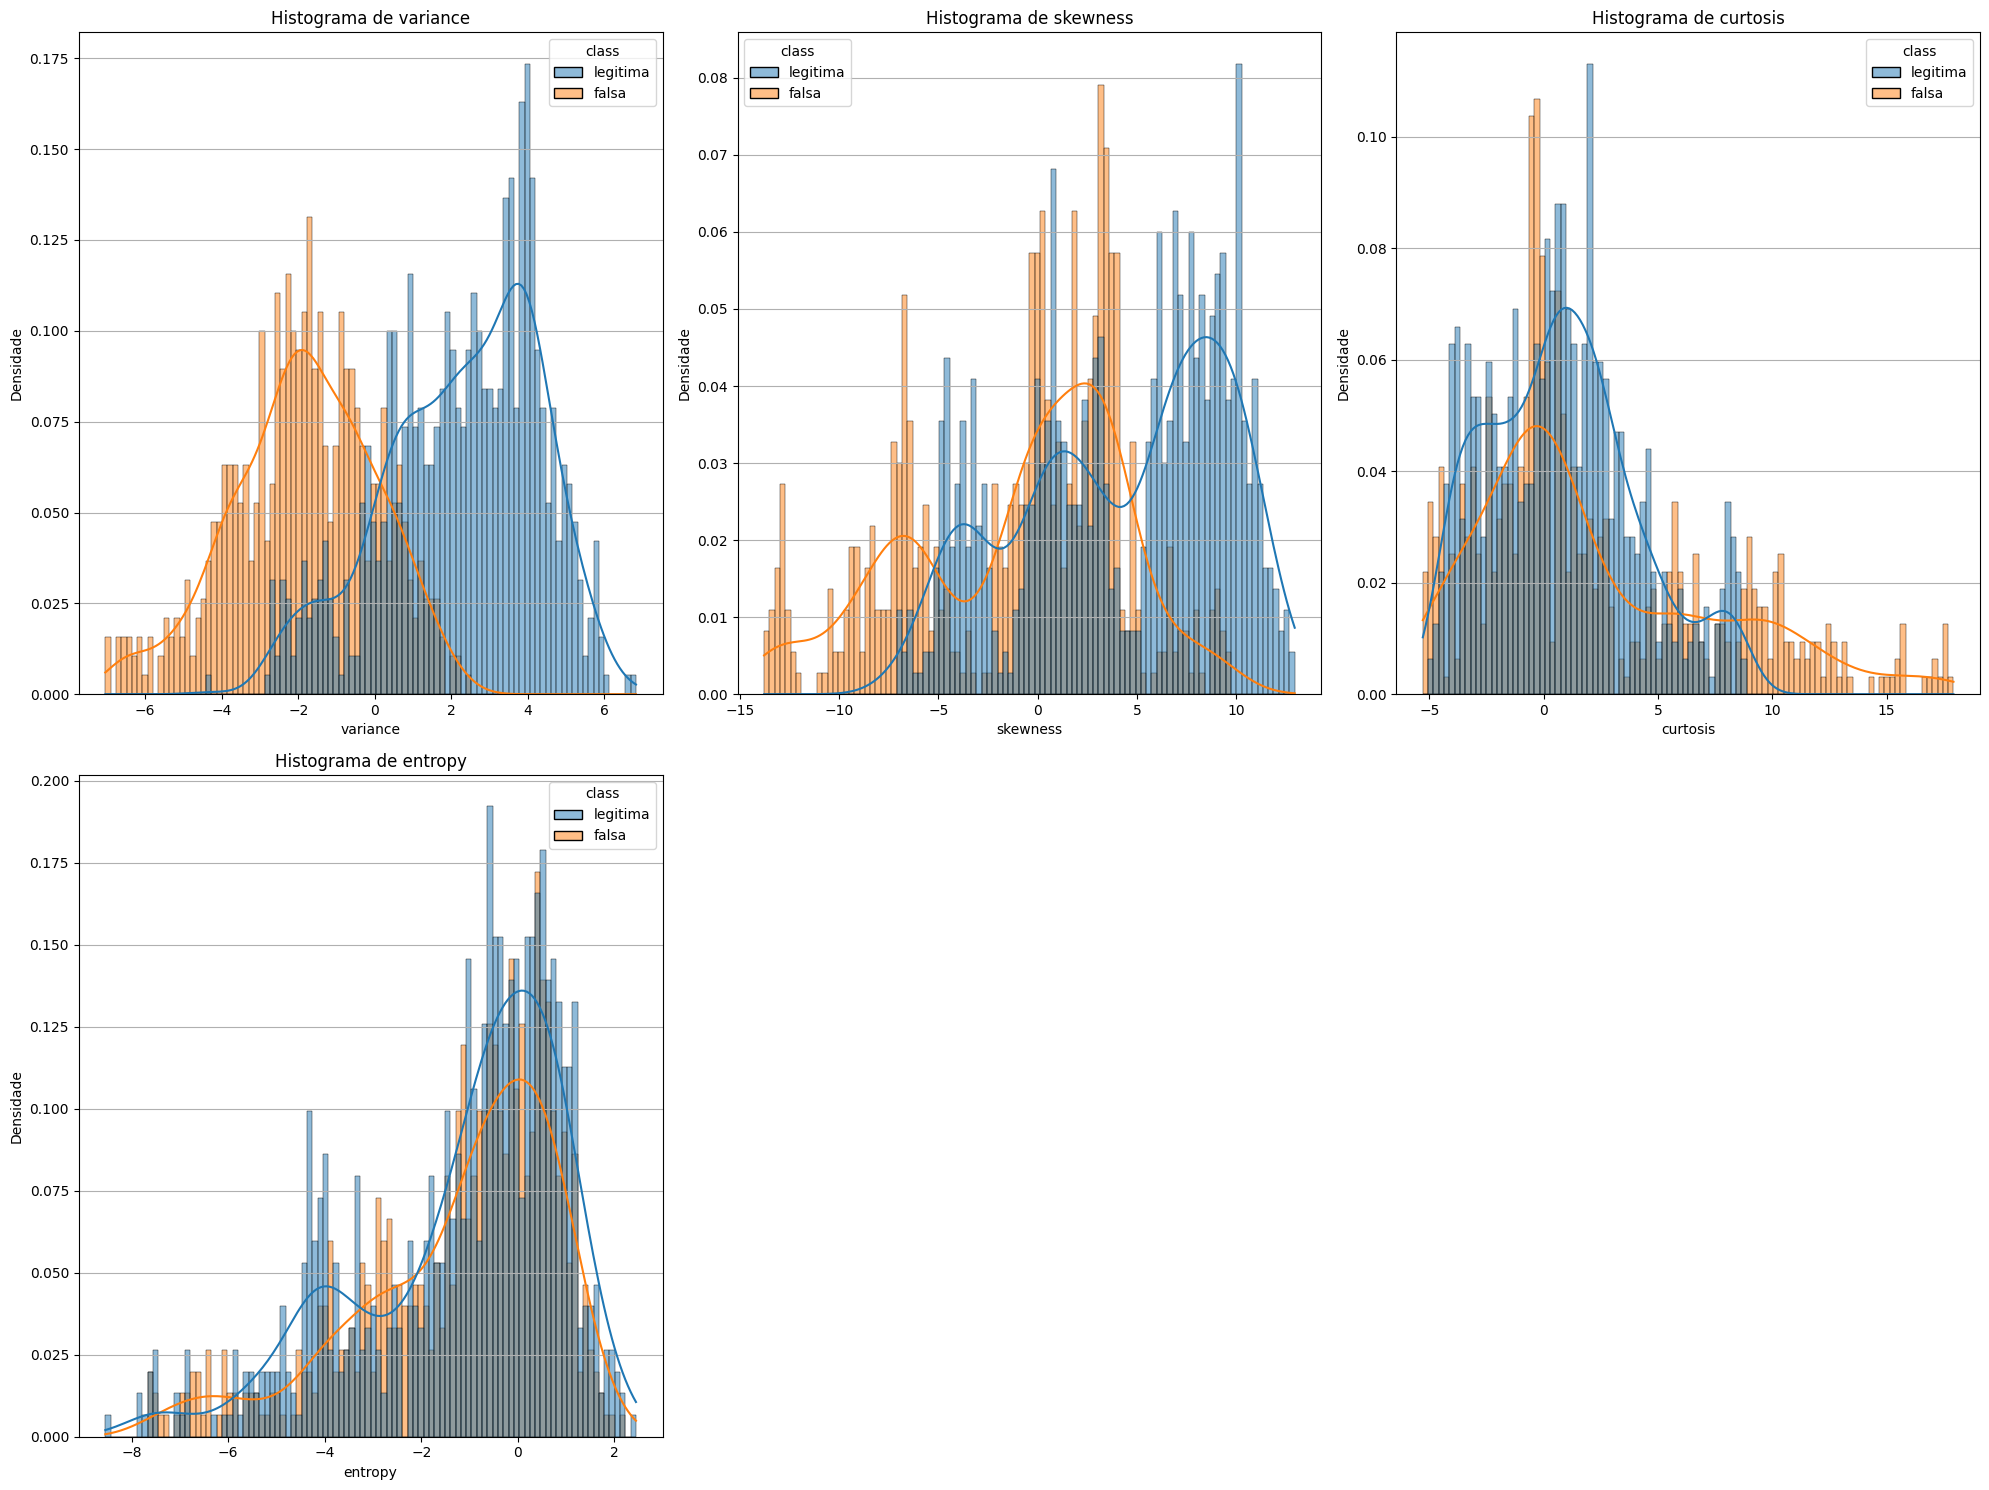

In [ ]:
plt.figure(figsize=(20, 15))

# Assuming 'dataset' is the DataFrame and 'class' is the target column
dataset_2 = dataset.copy()  # Creating a copy of the dataset to avoid modifying the original
dataset_2['class'] = dataset_2['class'].map({0: 'legitima', 1: 'falsa'})

# Now, proceed with plotting using dataset_2
for i, column in enumerate(dataset_2.columns.drop('class'), 1):
    plt.subplot(len(dataset_2.columns) // 3 + 1, 3, i)
    sns.histplot(data=dataset_2, x=column, hue='class', bins=100, kde=True, stat='density', alpha=0.5)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Densidade')
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

Baseado nos resultados acima vemos que os dados não possuem outliers que podem afetar consideravelmente a classificação do modelo. Adicionalmente, o dataset não contém variáveis categóricas que precisam ser transformadas. Por último, iremos utilizar um algoritmo baseado em árvore de decisão, [RandomForestClassifier](https://https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 que não requer a normalização nem a padronização, portanto podemos seguir a classificação.

Um ponto interessante sobre os dados acima é que a medida de variância é que a mais consegue separar entre notas legítimas e falsas, observado pelo histograma.

In [ ]:
# Separando os dados entre treinamento e teste
# 40% para teste e 60% para validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=122024)


In [ ]:
# modelo
model = RandomForestClassifier(random_state=122024)

# Treinando o modelo
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=122024)

In [ ]:
# Otimizando parâmetros do modelo
# Definir o grid de parâmetros para a busca
param_grid = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True, False]}

# Realizar a busca com validação cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros
print("Melhores parâmetros encontrados:", grid_search.best_params_)

# Melhor modelo
best_model = grid_search.best_estimator_

# Avaliar o modelo nos dados de teste
print(f"Acurácia no conjunto de teste: {best_model.score(X_test, y_test)}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Melhores parâmetros encontrados: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5}
Acurácia no conjunto de teste: 0.970856102003643


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Agora usaremos os parâmetros encontrados para rodar o modelo:


In [ ]:
model_optimized = RandomForestClassifier(bootstrap= False,
                                         max_depth= 5,
                                         min_samples_leaf= 2,
                                         min_samples_split= 2,
                                         n_estimators= 5,
                                         random_state=122024)

# Treinando o modelo
model_optimized.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=2,
                       n_estimators=5, random_state=122024)

In [ ]:
#criando a predição
y_pred = model_optimized.predict(X_test)


In [ ]:
#avaliando o resultado com a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)

print(matriz_confusao)

[[307  12]
 [  4 226]]


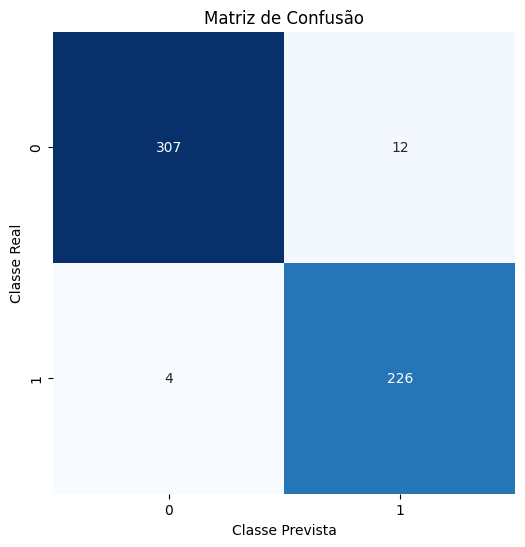

In [ ]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

In [ ]:
#metricas de avaliação
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.96      0.97       319
           1       0.95      0.98      0.97       230

    accuracy                           0.97       549
   macro avg       0.97      0.97      0.97       549
weighted avg       0.97      0.97      0.97       549



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

ROC-AUC médio na validação cruzada: 0.997


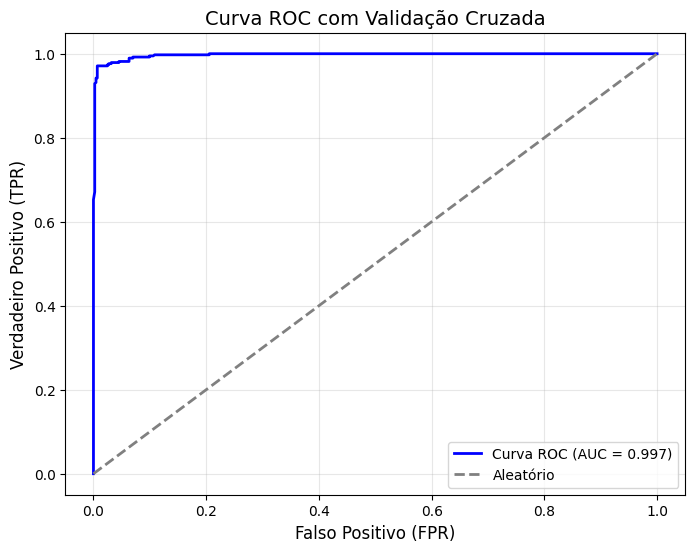

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


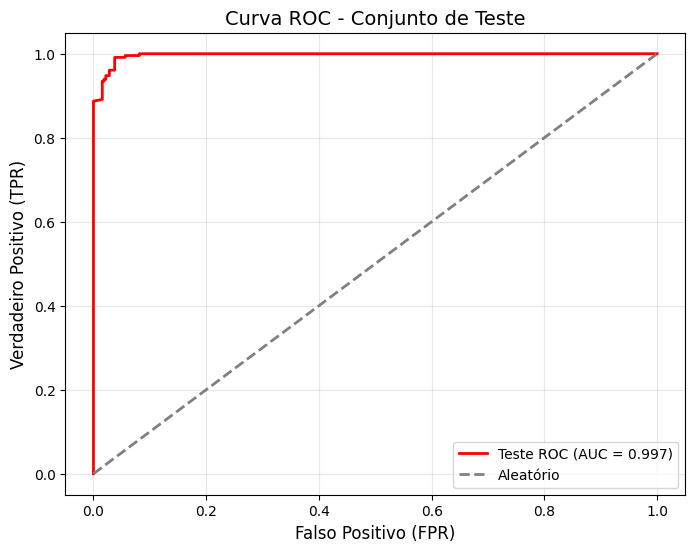

In [ ]:
# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_optimized, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"ROC-AUC médio na validação cruzada: {np.mean(cv_scores):.3f}")

# Previsões em validação cruzada para obter probabilidades
y_pred_proba_cv = cross_val_predict(model_optimized, X_train, y_train['class'], cv=cv, method='predict_proba')[:, 1]

# Calcular a curva ROC para a validação cruzada
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC com Validação Cruzada', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Ajustar o modelo no conjunto de treinamento e avaliar no conjunto de teste
model_optimized.fit(X_train, y_train)
y_pred_proba_test = model_optimized.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Adicionar a curva ROC do conjunto de teste para comparação
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Teste ROC (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC - Conjunto de Teste', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Como podemos observar nos dados acima, esse conjunto de dados tem uma acurácia muito alta, iremos usar uma GAN para gerar dados falsos na classe 0 e reavaliar o desempenho do modelo otimizado.

In [ ]:
# Código para gerar a GAN


# Dimensões do problema
input_dim = X_train.shape[1]  # Dimensão das features
noise_dim = 500  # Dimensão do ruído para o gerador

# Criar o modelo do Discriminador
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Criar o modelo do Gerador
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=noise_dim, activation='relu'),
        tf.keras.layers.Dense(input_dim, activation='tanh')
    ])
    return model

# Criar o modelo GAN (Gerador + Discriminador)
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential([generator, discriminator])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# Inicialização dos modelos
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

# Função para treinar a GAN
def train_gan(epochs, batch_size, noise_dim, X_train):
    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Treinar o discriminador
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        # Use .iloc to access rows by index and .values to get the NumPy array
        real_data = X_train.iloc[idx].values
        fake_data = generator.predict(np.random.randn(half_batch, noise_dim))

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))

        # Treinar o gerador
        noise = np.random.randn(batch_size, noise_dim)
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch}/{epochs} [D loss: {0.5 * (d_loss_real[0] + d_loss_fake[0])}] [G loss: {g_loss}]")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Adicionando GAN no conjunto de treino

In [ ]:
# Treinar a GAN
train_gan(epochs=100, batch_size=64, noise_dim=noise_dim, X_train=X_train)

# Gerar novos dados com o gerador
gan_generated_data = generator.predict(np.random.randn(200, noise_dim))  # 200 amostras geradas

generated_labels = np.zeros(len(gan_generated_data), dtype=int)  # Rótulo 0 para os dados gerados

# Combinar dados reais e gerados
X_combined = np.vstack([X_train, gan_generated_data])

# Reshape generated_labels to have the same dimensions as y_train
generated_labels = generated_labels.reshape(-1, 1) # Reshape to 2D

#y_combined = np.hstack([y_train.values, generated_labels])  # if y_train is a pandas DataFrame
y_combined = np.vstack([y_train, generated_labels]) # Use vstack and then reshape

# Reshape to the desired shape if needed
y_combined = y_combined.reshape(-1) # Reshape to 1D

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0/100 [D loss: 0.554993212223053] [G loss: [array(0.6150602, dtype=float32), array(0.6150602, dtype=float32), array(0.53125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
# Treinar o modelo com os dados combinados
model_optimized.fit(X_combined, y_combined)

# Avaliar no conjunto de teste
y_pred = model_optimized.predict(X_test)
print("Relatório de Classificação:\n", classification_report(y_test, y_pred))


Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       319
           1       0.98      0.97      0.97       230

    accuracy                           0.98       549
   macro avg       0.98      0.97      0.98       549
weighted avg       0.98      0.98      0.98       549



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
#avaliando o resultado com a matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)

print(matriz_confusao)

[[314   5]
 [  8 222]]


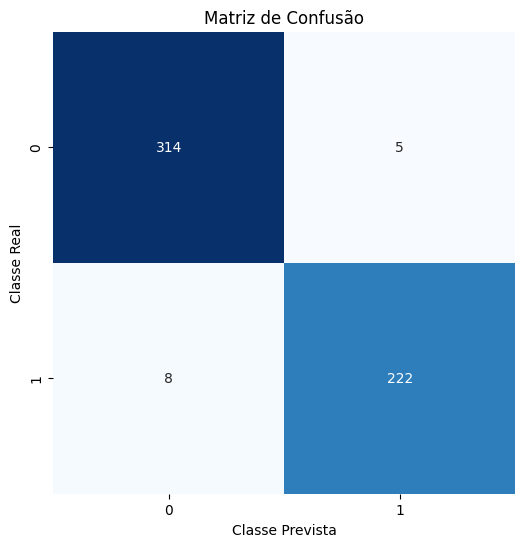

In [ ]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

ROC-AUC médio na validação cruzada: 0.998


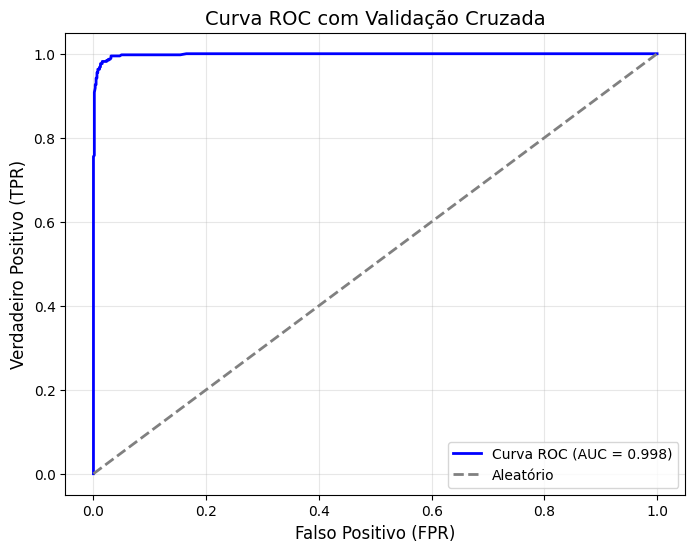

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


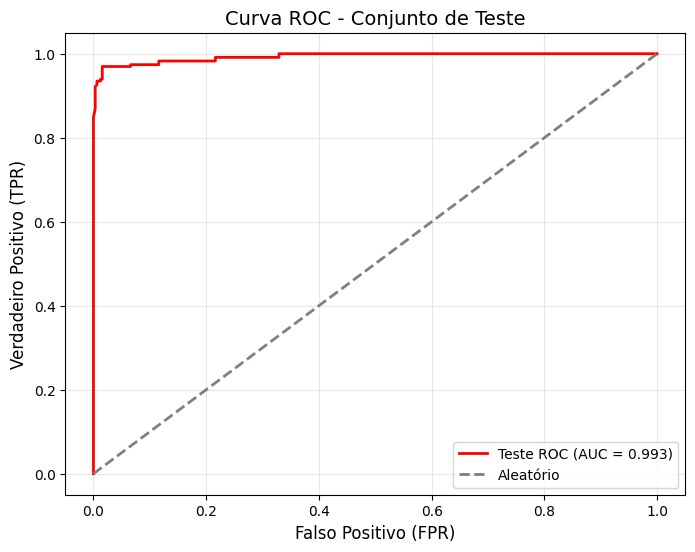

In [ ]:
# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_optimized, X_combined, y_combined, cv=cv, scoring='roc_auc')
print(f"ROC-AUC médio na validação cruzada: {np.mean(cv_scores):.3f}")

# Previsões em validação cruzada para obter probabilidades
y_pred_proba_cv = cross_val_predict(model_optimized, X_combined, y_combined, cv=cv, method='predict_proba')[:, 1]

# Calcular a curva ROC para a validação cruzada
fpr, tpr, thresholds = roc_curve(y_combined, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC com Validação Cruzada', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Ajustar o modelo no conjunto combinado e avaliar no conjunto de teste
model_optimized.fit(X_combined, y_combined)
y_pred_proba_test = model_optimized.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Adicionar a curva ROC do conjunto de teste para comparação
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Teste ROC (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC - Conjunto de Teste', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


Como observado acima a adição da GAN nos dados de treino teve pouco impacto no desempenho do modelo.

### Adicionando GAN no conjunto de teste
* Treinamento ocorrerá com o conjunto de dados original.



In [ ]:
# Gerar novos dados com o gerador para adicionar ao conjunto de teste
gan_test_data = generator.predict(np.random.randn(100, noise_dim))  # 100 amostras geradas
gan_test_labels = np.zeros(len(gan_test_data), dtype=int)  # Rótulo 0 para os dados gerados

# Combinar os dados do conjunto de teste com os gerados
X_test_augmented = np.vstack([X_test, gan_test_data])

# Use vstack to combine labels vertically, ensuring both are 2D
#y_test_augmented = np.hstack([y_test, gan_test_labels.reshape(-1, 1)])  # Incorrect: hstack is used for horizontal stacking
y_test_augmented = np.vstack([y_test.values.reshape(-1, 1), gan_test_labels.reshape(-1, 1)]) # Assuming y_test is a Pandas Series

# Flatten if needed:
y_test_augmented = y_test_augmented.reshape(-1)

# Treinar o modelo no conjunto original
model_optimized.fit(X_train, y_train)

# Avaliar no conjunto de teste aumentado
y_pred_augmented = model_optimized.predict(X_test_augmented)
print("Relatório de Classificação (com GAN no teste):\n", classification_report(y_test_augmented, y_pred_augmented))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Relatório de Classificação (com GAN no teste):
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       419
           1       0.67      0.98      0.80       230

    accuracy                           0.82       649
   macro avg       0.83      0.86      0.82       649
weighted avg       0.87      0.82      0.83       649



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#avaliando o resultado com a matriz de confusão
matriz_confusao = confusion_matrix(y_test_augmented, y_pred_augmented)

print(matriz_confusao)

[[307 112]
 [  4 226]]


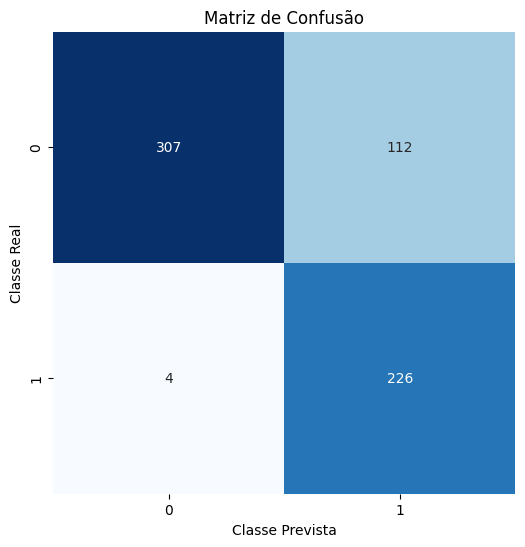

In [ ]:
# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.show()

ROC-AUC médio na validação cruzada: 0.997


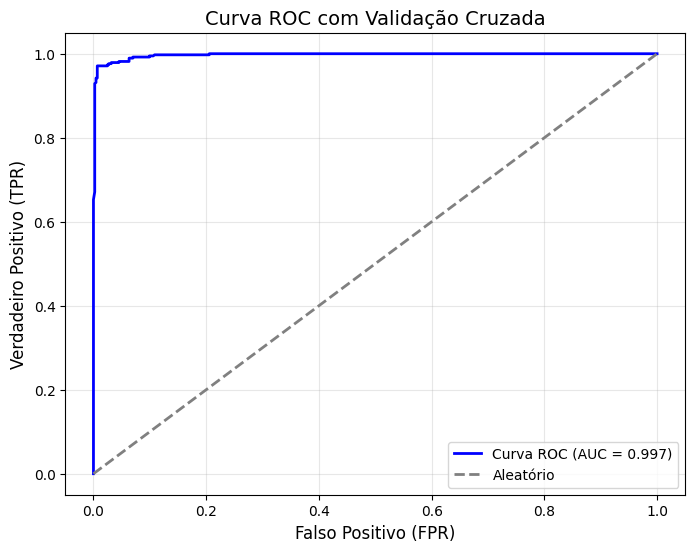

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


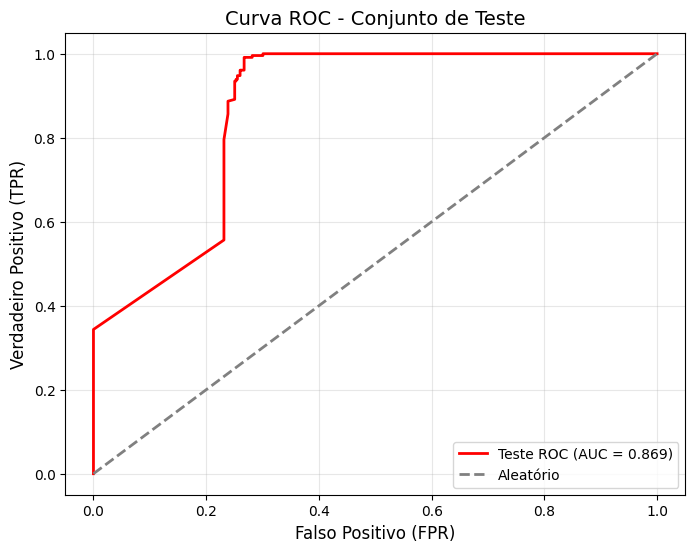

In [ ]:
# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_optimized, X_train, y_train['class'], cv=cv, scoring='roc_auc') # Access the 'class' column of y_train
print(f"ROC-AUC médio na validação cruzada: {np.mean(cv_scores):.3f}")

# Previsões em validação cruzada para obter probabilidades
y_pred_proba_cv = cross_val_predict(model_optimized, X_train, y_train['class'], cv=cv, method='predict_proba')[:, 1] # Access the 'class' column of y_train

# Calcular a curva ROC para a validação cruzada
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC com Validação Cruzada', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Ajustar o modelo no conjunto combinado e avaliar no conjunto de teste
model_optimized.fit(X_train, y_train,)
y_pred_proba_test = model_optimized.predict_proba(X_test_augmented)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_augmented, y_pred_proba_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Adicionar a curva ROC do conjunto de teste para comparação
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Teste ROC (AUC = {roc_auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório')
plt.xlabel('Falso Positivo (FPR)', fontsize=12)
plt.ylabel('Verdadeiro Positivo (TPR)', fontsize=12)
plt.title('Curva ROC - Conjunto de Teste', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


Como esperado no conjunto de treino a GAN, que foi treinada com os dados do X_train original, sendo alocada apenas na classe 0 impactou o desempenho do modelo.


# Conclusão:

O uso da GAN no conjunto de treinamento do modelo, não teve impacto na perfomance do modelo, fazendo com ele desempenhe a classificação de forma correta entre as classes. Ou seja, apesar de ter sido alocado apenas para a classe 0, o modelo conseguiu identificar corretamente as classes. Isso ocorreu porque ao expor o modelo durante o treinamento aos dados da GAN ele foi preparado para lidar com a variação adicional, não ficando confuso com esses dados durante o teste com os dados originais.

Contudo, o modelo gerado com os dados originais, ao ser testado usando os dados reais mais os dados da GAN teve uma queda em perfomance, sendo confudido pelos dados falsos gerados pela GAN, porque esses dados foram suficientemente próximos às classes reais. Isso ocorreu porque o modelo não foi exposto a essa variação durante a fase de treinamento.

Deste modo, pode ser benefico usar GAN no treinamento dos modelos, uma vez que isso não afeta o seu desempenho na identificação de dados reais, para que eles estejam preparados a identificar e lidar com ruídos gerados artificialmente.

###[Sanity Check] Avaliando modelo exposto a GAN no treino e no teste.

Checando se o modelo perfoma bem ao ser treinado e exposto aos dados da GAN. Pelo observado no resultado abaixo o modelo treinado com os dados da GAN não teve perda de perfomance no teste. Esse check foi feito para confirmar essa hipótese.

In [ ]:
model_optimized.fit(X_combined, y_combined)
y_pred_train_test = model_optimized.predict(X_test_augmented)

In [ ]:
#avaliando o resultado com a matriz de confusão
matriz_confusao = confusion_matrix(y_test_augmented, y_pred_train_test)

print(matriz_confusao)

[[414   5]
 [  8 222]]


In [ ]:
print("Relatório de Classificação (com GAN no teste):\n", classification_report(y_test_augmented, y_pred_train_test))

Relatório de Classificação (com GAN no teste):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       419
           1       0.98      0.97      0.97       230

    accuracy                           0.98       649
   macro avg       0.98      0.98      0.98       649
weighted avg       0.98      0.98      0.98       649

